#**DLAI Project 2019**

  - Lluís Guardia
  - Sergi Sánchez
  - Miguel Ángel Bueno
  - Juan José Nieto

In [0]:
import torch
import os
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import defaultdict
from torchvision.utils import save_image, make_grid
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import copy 
from prettytable import PrettyTable

def setSeed(manualSeed):
	np.random.seed(manualSeed)
	torch.manual_seed(manualSeed)
	torch.cuda.manual_seed(manualSeed)
	torch.cuda.manual_seed_all(manualSeed)

	torch.backends.cudnn.enabled = False
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True

setSeed(2)

In [0]:
hparams = {
    'batch_size':128,
    'num_epochs':7,
    'num_epochs_class':300,
    'num_epochs_gan':100,
    'num_classes':10,
    'pixels_inputs':784,
    'learning_rate':1e-3,
    'bottleneck_sizes': [16,64,256],
    'log_interval': 100
}

hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

#**PART 1**

##1. Load MNIST train and test sets. 

Split the original training data into 95% training and 5% validation data

In [21]:
percentage_train=0.95

mnist_trainset = MNIST('data', train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (0.5,))
                               ]))
mnist_testset = MNIST('data', train=False, 
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,), (0.5,))
                              ]))

train_size = int(percentage_train * len(mnist_trainset))
val_size = len(mnist_trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_trainset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=hparams['batch_size'],
    shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=hparams['batch_size'], 
    shuffle=False)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams['batch_size'], 
    shuffle=False)

print('\nTraining set is :{}%'.format(100*len(train_dataset)/len(mnist_trainset)))
print('Validation set is :{}%'.format(100*len(val_dataset)/len(mnist_trainset)))


Training set is :95.0%
Validation set is :5.0%


##2. Implement a convolutional autoencoder 

with separate Encoder and Decoder modules

In [0]:
class Encoder(nn.Module):
    def __init__(self, bottleneck):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2)
            )
    
        self.inn = nn.Sequential(
              nn.Linear(16*3*3, bottleneck),
              nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x= x.view(x.shape[0], -1)
        return self.inn(x)

In [0]:
class Decoder(nn.Module):
    def __init__(self, bottleneck):
        super(Decoder, self).__init__()
        
        self.out = nn.Sequential(
              nn.Linear(bottleneck, 16*3*3),
              nn.ReLU()
              )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 7, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 8, stride=2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.out(x)
        x = x.view(x.shape[0], 16, 3, 3)       
        x = self.decoder(x)
        return x

In [27]:
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self, bottleneck):
        super(ConvolutionalAutoEncoder, self).__init__()

        self.bottleneck = bottleneck

        self.encoder = Encoder(bottleneck)
        self.decoder = Decoder(bottleneck)


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

image = torch.randn((1, 1, 28, 28))
autoencoder = ConvolutionalAutoEncoder(50).to(hparams['device'])
output = autoencoder(image.to(hparams['device']))
print('Size of image after passing through the AutoEncoder is {}'.format(output.shape))

Size of image after passing through the AutoEncoder is torch.Size([1, 1, 28, 28])


###Functions to load and save models

In [0]:
path = "/content/gdrive/My Drive/DLAI_PROJECT/" 

def load_weights(name):
  return torch.load(os.path.join(path, name + '.pt'))
def save_model(name, weights):
  torch.save(weights, os.path.join(path, name + '.pt'))

##3. Train the convolutional autoencoder, with different bottleneck sizes. 

Plot the train and validation loss curves of all autoencoders in the same figure.

In [0]:
def train_epoch(model, train_data, optimizer, criterion, hparams, classify, print_batch):
  model.train()
  device = hparams['device']
  loss_epoch=[]
  for batch_idx, (data, target) in enumerate(train_data):  
      img = data.to(device)
      optimizer.zero_grad()
      output = model(img)

      if classify:
        loss = criterion(output, target.cuda().long())
      else:
        loss = criterion(output, img)*hparams['pixels_inputs']

      loss.backward()
      optimizer.step()
      loss_epoch.append(loss.item())     
      
      if print_batch:
        if batch_idx % hparams['log_interval'] == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, hparams['num_epochs'],  batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
  return loss_epoch

In [0]:
def test_epoch(model, test_data, criterion, hparams):
  model.eval()
  device = hparams['device']
  mean_loss = 0
  
  with torch.no_grad():
      for data in test_data:
            img, _ = data
            img = img.to(device)
            output = model(img)
            loss = criterion(output, img)*hparams['pixels_inputs']
            mean_loss += loss.item()

      mean_loss = mean_loss/len(test_data)
  return mean_loss 

In [0]:
criterion = nn.MSELoss() 

losses = defaultdict(lambda: defaultdict(list))
models = []
for bt in hparams['bottleneck_sizes']:
    models.append(ConvolutionalAutoEncoder(bt).cuda())
for m in models:
    print('Model with '+str(m.bottleneck)+' bottleneck size:')
    params = list(m.encoder.parameters()) + list(m.decoder.parameters())
    optimizer = torch.optim.Adam(params, lr=hparams['learning_rate'], weight_decay=1e-5)
    for epoch in range(hparams['num_epochs']):
      loss_train = train_epoch(m, train_loader, optimizer, criterion, hparams, False, True)
      loss_val = test_epoch(m, test_loader, criterion, hparams)
      losses[m.bottleneck]['train'].append(loss_train)
      losses[m.bottleneck]['test'].append(loss_val)
      print('Test set Epoch: {}/{} \tAverage Loss: {:.6f}\n'.format(
          epoch+1, hparams['num_epochs'], loss_val))

Model with 16 bottleneck size:
Train Epoch: 1/7 [0/57000 (0%)]	Loss: 782.565308
Train Epoch: 1/7 [12800/57000 (22%)]	Loss: 357.482910
Train Epoch: 1/7 [25600/57000 (45%)]	Loss: 349.613831
Train Epoch: 1/7 [38400/57000 (67%)]	Loss: 335.491333
Train Epoch: 1/7 [51200/57000 (90%)]	Loss: 350.875488
Test set Epoch: 1/7 	Average Loss: 357.118549

Train Epoch: 2/7 [0/57000 (0%)]	Loss: 346.291443
Train Epoch: 2/7 [12800/57000 (22%)]	Loss: 354.251099
Train Epoch: 2/7 [25600/57000 (45%)]	Loss: 335.739197
Train Epoch: 2/7 [38400/57000 (67%)]	Loss: 342.621643
Train Epoch: 2/7 [51200/57000 (90%)]	Loss: 346.353912
Test set Epoch: 2/7 	Average Loss: 356.416925

Train Epoch: 3/7 [0/57000 (0%)]	Loss: 343.782043
Train Epoch: 3/7 [12800/57000 (22%)]	Loss: 365.568604
Train Epoch: 3/7 [25600/57000 (45%)]	Loss: 341.014221
Train Epoch: 3/7 [38400/57000 (67%)]	Loss: 342.681122
Train Epoch: 3/7 [51200/57000 (90%)]	Loss: 184.912231
Test set Epoch: 3/7 	Average Loss: 171.588587

Train Epoch: 4/7 [0/57000 (0%)]	L

In [0]:
##SAVE MODELS
for m in models:
  save_model(str(m.bottleneck), m.state_dict())

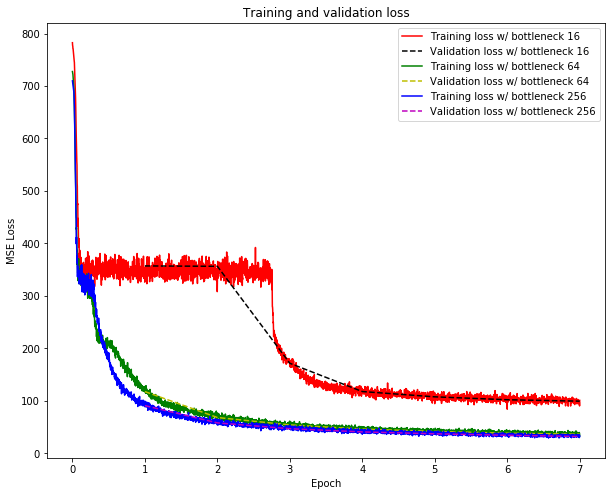

In [0]:
plt.figure(figsize=(10, 8))
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

bottlenecks = hparams['bottleneck_sizes']
colors_train = ['r', 'g', 'b']
colors_val = ['k', 'y', 'm']

num_batch =np.ceil(len(train_loader.dataset)/hparams['batch_size'])
x_t = list(np.linspace(0,hparams['num_epochs'],num_batch*hparams['num_epochs']))
x_v = list(range(1, hparams['num_epochs']+1))

for bt, ct, cv in zip(bottlenecks, colors_train, colors_val):
  y_t = np.array(losses[bt]['train']).flatten()
  y_v = losses[bt]['test']
  plt.plot(x_t, y_t, ct, label='Training loss w/ bottleneck ' + str(bt))
  plt.plot(x_v, y_v, cv + '--', label='Validation loss w/ bottleneck ' + str(bt))

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
# Execute only in case we want to use already trained models. Weights stored in Google Drive.
models = []
bottlenecks = [10,50,100,512]
for bt in bottlenecks:
  m = ConvolutionalAutoEncoder(bt).cuda()
  weights = load_weights(str(bt))
  m.load_state_dict(weights)
  models.append(m)

##4. Compute the avg. image reconstruction error (MSE) 

of the trained models on the MNIST validation and test sets. 

Show the results in a table, including #params of each model.

In [0]:
def get_nn_nparams(model):
  pp=0
  for p in list(model.parameters()):
      nn=1
      for s in list(p.size()):
          nn = nn*s
      pp += nn
  return pp

In [0]:
mse_eval = []
mse_test = []

t = PrettyTable(['bottleneck size', 'MSE eval', 'MSE test', 'parameters'])

for mod, n in zip(models, range(len(models))):
  mse_eval.append(test_epoch(mod, val_loader, criterion, hparams))
  mse_test.append(test_epoch(mod, test_loader, criterion, hparams))
  t.add_row([hparams['bottleneck_sizes'][n], mse_eval[n], mse_test[n], get_nn_nparams(mod)])

print(t)

+-----------------+--------------------+-------------------+------------+
| bottleneck size |      MSE eval      |      MSE test     | parameters |
+-----------------+--------------------+-------------------+------------+
|        16       | 100.73494911193848 | 99.41435347931295 |   13833    |
|        64       | 37.71660343805949  |  36.5419301383103 |   27705    |
|       256       |  33.1649223168691  | 32.05052238174632 |   83193    |
+-----------------+--------------------+-------------------+------------+


##5. Select one of the autoencoders and feed it 5 random MNIST images from the test set. 

Show them along with their reconstructions.

<Figure size 432x288 with 0 Axes>

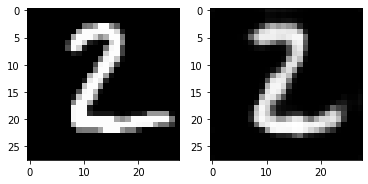

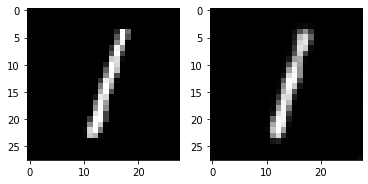

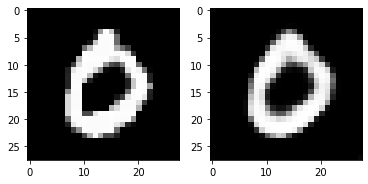

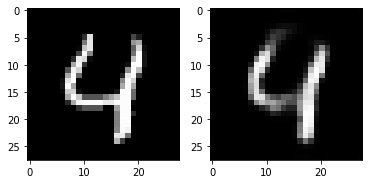

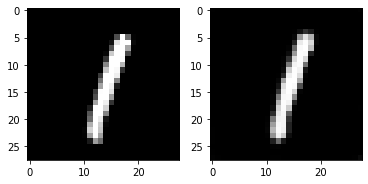

In [0]:
model_used = models[1]

dataiter = iter(test_loader)
images, _ = dataiter.next()

figure = plt.figure()
num_of_images = 5

for index in range(1, num_of_images + 1):
    img=images[index].reshape(1, 1, 28, 28).to(hparams['device'])
    img = Variable(img.cuda())
    output = model_used(img)

    img=img.reshape(28, 28)
    output = output.reshape(28, 28)
    
    a = img.detach().cpu().numpy()
    b = output.detach().cpu().numpy()
    f, arr = plt.subplots(1,2)

    arr[0].imshow(a, cmap='gray')
    arr[1].imshow(b, cmap='gray')
    plt.show()

##6. Generate 5 new images by injecting random values as input to the decoder.

Image 0


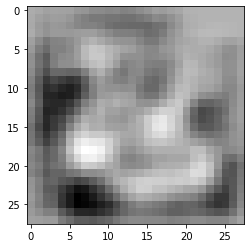

Image 1


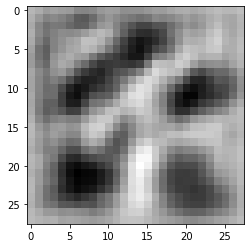

Image 2


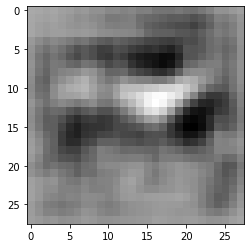

Image 3


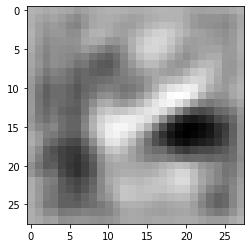

Image 4


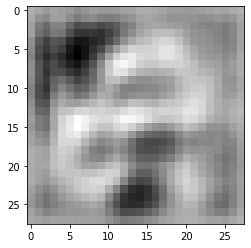

In [0]:
model_used = models[1]
for n in range(5):
  noise_image = torch.randn([1,model_used.bottleneck]).cuda()

  output = model_used.decoder(noise_image)
  print('Image '+str(n))
  plt.imshow(output.cpu().detach().numpy().squeeze(), cmap='gray')
  plt.show()  

#**PART 2:**

##1. Select a subset of 100 images and their associated labels from the MNIST training data.

In [0]:
sub_size = 100
sub_dataset, _ = torch.utils.data.random_split(mnist_trainset, [sub_size, len(mnist_trainset)-sub_size])

sub_loader = torch.utils.data.DataLoader(
      sub_dataset,
      batch_size=100,
      shuffle=True)

##2 & 3. Select one of the previously trained autoencoders.

Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.

In [0]:
class Classifier(nn.Module):
  def __init__(self, bottleneck):
    super(Classifier, self).__init__()
    self.bottleneck = bottleneck
    self.encoder = Encoder(bottleneck)
    self.linear = nn.Sequential(
              nn.Linear(bottleneck, 10),
              nn.ReLU())
    self.softmax = nn.Softmax()

  def forward(self, x):
    x = self.encoder(x)
    x = self.linear(x)
    return self.softmax(x)

##4. Pre-training: 

use the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.

In [29]:
# weights = load_weights('final')

criterion = nn.CrossEntropyLoss()
loss_classifiers = defaultdict(lambda: defaultdict(list))

bt = 64
model_base = models[1]
# model_base.load_state_dict(weights)

<All keys matched successfully>

In [35]:
model_init = Classifier(bt).cuda()
model_init.encoder = copy.deepcopy(model_base.encoder)

params = list(model_init.encoder.parameters()) + list(model_init.linear.parameters())
optimizer = torch.optim.Adam(params, lr=hparams['learning_rate'], weight_decay=1e-5)

print('Model with '+str(model_init.bottleneck)+' bottleneck size:')
for epoch in range(hparams['num_epochs_class']):
  train_loss = train_epoch(model_init, sub_loader, optimizer, criterion, hparams, True, False)
  loss_classifiers['init']['train'].append(train_loss)
  if epoch % 10 == 0:
    print('Train Epoch: {}/{} \tAverage Loss: {:.6f}'.format(
        epoch+1, hparams['num_epochs_class'], np.mean(train_loss)))

Model with 256 bottleneck size:
Train Epoch: 1/300 	Average Loss: 2.384113


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Train Epoch: 11/300 	Average Loss: 2.040144
Train Epoch: 21/300 	Average Loss: 1.909382
Train Epoch: 31/300 	Average Loss: 1.840991
Train Epoch: 41/300 	Average Loss: 1.833086
Train Epoch: 51/300 	Average Loss: 1.830204
Train Epoch: 61/300 	Average Loss: 1.827466
Train Epoch: 71/300 	Average Loss: 1.790704
Train Epoch: 81/300 	Average Loss: 1.726395
Train Epoch: 91/300 	Average Loss: 1.679424
Train Epoch: 101/300 	Average Loss: 1.654350
Train Epoch: 111/300 	Average Loss: 1.649041
Train Epoch: 121/300 	Average Loss: 1.645787
Train Epoch: 131/300 	Average Loss: 1.640857
Train Epoch: 141/300 	Average Loss: 1.637596
Train Epoch: 151/300 	Average Loss: 1.636047
Train Epoch: 161/300 	Average Loss: 1.633410
Train Epoch: 171/300 	Average Loss: 1.631069
Train Epoch: 181/300 	Average Loss: 1.630113
Train Epoch: 191/300 	Average Loss: 1.629847
Train Epoch: 201/300 	Average Loss: 1.629753
Train Epoch: 211/300 	Average Loss: 1.629700
Train Epoch: 221/300 	Average Loss: 1.629661
Train Epoch: 231/30

##5. Fine-tuning: 

do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.

In [36]:
model_finetuned = Classifier(bt).cuda()
model_finetuned.encoder = copy.deepcopy(model_base.encoder)

optimizer = torch.optim.Adam([
                {'params': model_finetuned.linear.parameters()},
                {'params': model_finetuned.encoder.parameters(), 'lr': 1e-7}
            ], hparams['learning_rate'], weight_decay=1e-5)

print('Model with '+str(model_finetuned.bottleneck)+' bottleneck size:')
for epoch in range(hparams['num_epochs_class']):
  train_loss = train_epoch(model_finetuned, sub_loader, optimizer, criterion, hparams, True, False)
  loss_classifiers['finetuned']['train'].append(train_loss)
  if epoch % 10 == 0:
    print('Train Epoch: {}/{} \tAverage Loss: {:.6f}'.format(
        epoch+1, hparams['num_epochs_class'], np.mean(train_loss)))

Model with 256 bottleneck size:
Train Epoch: 1/300 	Average Loss: 2.385386


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Train Epoch: 11/300 	Average Loss: 2.257761
Train Epoch: 21/300 	Average Loss: 2.135377
Train Epoch: 31/300 	Average Loss: 2.092981
Train Epoch: 41/300 	Average Loss: 2.038461
Train Epoch: 51/300 	Average Loss: 1.972941
Train Epoch: 61/300 	Average Loss: 1.930737
Train Epoch: 71/300 	Average Loss: 1.874149
Train Epoch: 81/300 	Average Loss: 1.842771
Train Epoch: 91/300 	Average Loss: 1.829893
Train Epoch: 101/300 	Average Loss: 1.823395
Train Epoch: 111/300 	Average Loss: 1.820074
Train Epoch: 121/300 	Average Loss: 1.818125
Train Epoch: 131/300 	Average Loss: 1.816772
Train Epoch: 141/300 	Average Loss: 1.815763
Train Epoch: 151/300 	Average Loss: 1.814971
Train Epoch: 161/300 	Average Loss: 1.814313
Train Epoch: 171/300 	Average Loss: 1.813737
Train Epoch: 181/300 	Average Loss: 1.813212
Train Epoch: 191/300 	Average Loss: 1.812714
Train Epoch: 201/300 	Average Loss: 1.812213
Train Epoch: 211/300 	Average Loss: 1.811636
Train Epoch: 221/300 	Average Loss: 1.810754
Train Epoch: 231/30

##6. From scratch: 

train the model on the 100 samples without reusing the decoder weights at all.

In [37]:
model_simple = Classifier(bt).cuda()

optimizer = torch.optim.Adam(model_simple.parameters(), lr=hparams['learning_rate'], weight_decay=1e-5)

print('Model with '+str(model_simple.bottleneck)+' bottleneck size:')
for epoch in range(hparams['num_epochs_class']):
  train_loss = train_epoch(model_finetuned, sub_loader, optimizer, criterion, hparams, True, False)
  loss_classifiers['simple']['train'].append(train_loss)
  if epoch % 10 == 0:
    print('Train Epoch: {}/{} \tAverage Loss: {:.6f}'.format(
        epoch+1, hparams['num_epochs_class'], np.mean(train_loss)))

Model with 256 bottleneck size:
Train Epoch: 1/300 	Average Loss: 1.789880


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Train Epoch: 11/300 	Average Loss: 1.789880
Train Epoch: 21/300 	Average Loss: 1.789880
Train Epoch: 31/300 	Average Loss: 1.789879
Train Epoch: 41/300 	Average Loss: 1.789880
Train Epoch: 51/300 	Average Loss: 1.789880
Train Epoch: 61/300 	Average Loss: 1.789879
Train Epoch: 71/300 	Average Loss: 1.789880
Train Epoch: 81/300 	Average Loss: 1.789879
Train Epoch: 91/300 	Average Loss: 1.789879
Train Epoch: 101/300 	Average Loss: 1.789880
Train Epoch: 111/300 	Average Loss: 1.789880
Train Epoch: 121/300 	Average Loss: 1.789879
Train Epoch: 131/300 	Average Loss: 1.789880
Train Epoch: 141/300 	Average Loss: 1.789880
Train Epoch: 151/300 	Average Loss: 1.789880
Train Epoch: 161/300 	Average Loss: 1.789880
Train Epoch: 171/300 	Average Loss: 1.789880
Train Epoch: 181/300 	Average Loss: 1.789880
Train Epoch: 191/300 	Average Loss: 1.789880
Train Epoch: 201/300 	Average Loss: 1.789879
Train Epoch: 211/300 	Average Loss: 1.789880
Train Epoch: 221/300 	Average Loss: 1.789879
Train Epoch: 231/30

##7. Show the accuracy of the four models on the MNIST test set in a table.

In [0]:
def test_epoch_class(model, test_data, criterion, hparams):
  model.eval()
  device = hparams['device']
  mean_loss = 0
  mean_acc = 0
  
  with torch.no_grad():
      for data, target in test_data:
            img, label = data.to(device), target.to(device)

            output = model(img)
            loss = criterion(output, label)

            mean_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            mean_acc += pred.eq(label.view_as(pred)).sum().item()
   
  mean_loss = mean_loss/len(test_data)   
  mean_acc = mean_acc / len(test_data.dataset)

  return mean_loss, mean_acc

In [39]:
t2 = PrettyTable(['model', 'accuracy', 'loss'])

for mod, typ in zip([model_init, model_finetuned, model_simple], ['init', 'fine', 'simple']):
  loss,accuracy = test_epoch_class(mod, test_loader, criterion, hparams)
  t2.add_row([typ+' model', str(int(100*accuracy))+'%', loss])

print(t2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


+--------------+----------+--------------------+
|    model     | accuracy |        loss        |
+--------------+----------+--------------------+
|  init model  |   67%    | 1.7918822780440125 |
|  fine model  |   58%    | 1.8851397656187225 |
| simple model |    6%    | 2.3028343538694744 |
+--------------+----------+--------------------+


#**OPTIONAL A: VARIATIONAL AUTOENCODER**

1. Implement an autoencoder like that from Exercise 1, but turning the deterministic bottleneck into a stochastic bottleneck, with an isotropic Gaussian as distribution for the latent variables.
2. Train the model optimizing the Evidence Lower Bound (ELBO).
3. Generate samples with the decoder and show them.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load MNIST dataset


In [2]:
transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms)

test_dataset = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 10502984.75it/s]                           


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 141993.10it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2326993.33it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 53028.38it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


Define some parameters

In [0]:
BATCH_SIZE = 64     
N_EPOCHS = 30       
INPUT_DIM = 28 * 28  
HIDDEN_DIM = 256    
LATENT_DIM = 30     
lr = 1e-3  

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Define the new Autoencoder. For this exercise, we have observed that a simpler architecture using only linear layers performs better. The encoder only has one hidden layer, and we define the size of this hidden layer as well as the size of the latent dimension. 

In [0]:
class Encoder(nn.Module):

  def __init__(self, input_dim, hidden_dim, z_dim):

      super().__init__()

      self.linear = nn.Linear(input_dim, hidden_dim)
      self.mu = nn.Linear(hidden_dim, z_dim)
      self.var = nn.Linear(hidden_dim, z_dim)

  def forward(self, x):
      hidden = F.relu(self.linear(x))
      z_mu = self.mu(hidden)
      z_var = self.var(hidden)

      return z_mu, z_var

In [0]:
class Decoder(nn.Module):

    def __init__(self, z_dim, hidden_dim, output_dim):

        super().__init__()

        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        hidden = F.relu(self.linear(x))
        predicted = torch.sigmoid(self.out(hidden))

        return predicted

In [0]:
class VAE(nn.Module):

    def __init__(self, enc, dec):
        super().__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        z_mu, z_var = self.enc(x)

        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        predicted = self.dec(x_sample)
        return predicted, z_mu, z_var

Create an instance of the VAE and define the otimizer.

In [0]:
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)
model = VAE(encoder, decoder).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

Define the training and test loop. The VAE takes into account the Reconstruction Loss as well as the KL Divergence.

In [0]:
def train():
    model.train()
    train_loss = 0

    for i, (x, _) in enumerate(train_iterator):
        x = x.view(-1, 28 * 28)
        x = x.to(device)
        
        optimizer.zero_grad()
        x_sample, z_mu, z_var = model(x)

        recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)
        kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
        loss = recon_loss + kl_loss

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    return train_loss

In [0]:
def test():
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for i, (x, _) in enumerate(test_iterator):
            x = x.view(-1, 28 * 28)
            x = x.to(device)
            x_sample, z_mu, z_var = model(x)

            recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)
            kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
            loss = recon_loss + kl_loss
            test_loss += loss.item()

    return test_loss


Train the VAE

In [11]:
best_test_loss = float('inf')

for e in range(N_EPOCHS):

    train_loss = train()
    test_loss = test()

    train_loss /= len(train_dataset)
    test_loss /= len(test_dataset)

    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0, Train Loss: 157.16, Test Loss: 126.49
Epoch 1, Train Loss: 121.00, Test Loss: 116.09
Epoch 2, Train Loss: 114.34, Test Loss: 111.54
Epoch 3, Train Loss: 111.50, Test Loss: 109.77
Epoch 4, Train Loss: 109.89, Test Loss: 108.59
Epoch 5, Train Loss: 108.87, Test Loss: 107.84
Epoch 6, Train Loss: 108.12, Test Loss: 107.32
Epoch 7, Train Loss: 107.58, Test Loss: 106.56
Epoch 8, Train Loss: 107.11, Test Loss: 106.29
Epoch 9, Train Loss: 106.76, Test Loss: 106.31
Epoch 10, Train Loss: 106.48, Test Loss: 105.70
Epoch 11, Train Loss: 106.21, Test Loss: 106.05
Epoch 12, Train Loss: 105.97, Test Loss: 105.47
Epoch 13, Train Loss: 105.73, Test Loss: 105.42
Epoch 14, Train Loss: 105.59, Test Loss: 105.04
Epoch 15, Train Loss: 105.43, Test Loss: 105.12
Epoch 16, Train Loss: 105.30, Test Loss: 104.95
Epoch 17, Train Loss: 105.16, Test Loss: 104.72
Epoch 18, Train Loss: 105.03, Test Loss: 104.83
Epoch 19, Train Loss: 104.95, Test Loss: 104.57
Epoch 20, Train Loss: 104.85, Test Loss: 104.39
Ep

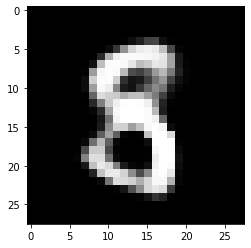

In [17]:
z = torch.randn(1, LATENT_DIM).to(device)

reconstructed_img = model.dec(z)
img = reconstructed_img.view(28, 28).data
img = img.cpu()

plt.imshow(img, cmap='gray')

#**OPTIONAL B: GAN**


In [0]:
batch_size = hparams['batch_size']

aux_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams['batch_size'],
    shuffle=True)

data_loader = aux_loader

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [0]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [0]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [0]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()

    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [0]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [0]:
for epoch in range(hparams['num_epochs_gan']):
    print('Starting epoch {}...'.format(epoch), end=' ')
    for i, (images, labels) in enumerate(data_loader):
        
        step = epoch * len(data_loader) + i + 1
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
            
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)    
        
    print('Done!')

Starting epoch 0... Done!
Starting epoch 1... Done!
Starting epoch 2... Done!
Starting epoch 3... Done!
Starting epoch 4... Done!
Starting epoch 5... Done!
Starting epoch 6... Done!
Starting epoch 7... Done!
Starting epoch 8... Done!
Starting epoch 9... Done!
Starting epoch 10... Done!
Starting epoch 11... Done!
Starting epoch 12... Done!
Starting epoch 13... Done!
Starting epoch 14... Done!
Starting epoch 15... Done!
Starting epoch 16... Done!
Starting epoch 17... Done!
Starting epoch 18... Done!
Starting epoch 19... Done!
Starting epoch 20... Done!
Starting epoch 21... Done!
Starting epoch 22... Done!
Starting epoch 23... Done!
Starting epoch 24... Done!
Starting epoch 25... Done!
Starting epoch 26... Done!
Starting epoch 27... Done!
Starting epoch 28... Done!
Starting epoch 29... Done!
Starting epoch 30... Done!
Starting epoch 31... Done!
Starting epoch 32... Done!
Starting epoch 33... Done!
Starting epoch 34... Done!
Starting epoch 35... Done!
Starting epoch 36... Done!
Starting ep

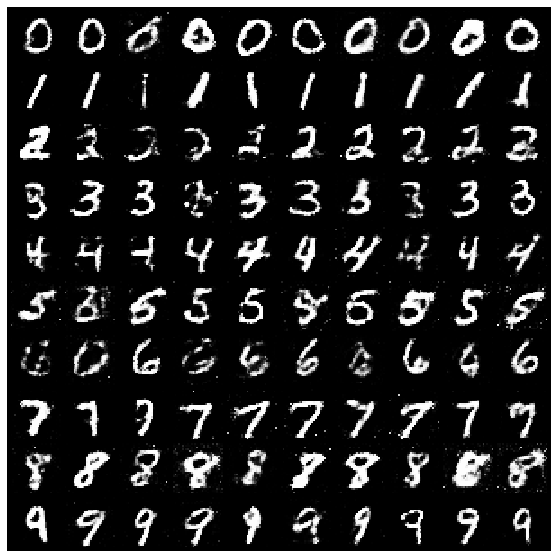

In [0]:
z = Variable(torch.randn(100, 100)).cuda()
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).cuda()
images = generator(z, labels).unsqueeze(1)
grid = make_grid(images, nrow=10, normalize=True)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1, 2, 0).detach().cpu().numpy(), cmap='binary')
ax.axis('off')
plt.show()